# Time series analysis - Example of predicting transformed data.
**Lund University, Lund, Sweden**

**Reference:** "An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson, Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

from tsa_lth.analysis import acf, pacf, plotACFnPACF, box_cox, normplot
from tsa_lth.tests import whiteness_test, check_if_normal
from tsa_lth.modelling import estimateARMA, polydiv

np.random.seed(50)
extraN = 400
N = 1200
valStart = 900
noLags = 100
time = np.arange(1, N+1) / N * 45 * 12 * 2
k = 4

# Simulate and plot a transformed process.

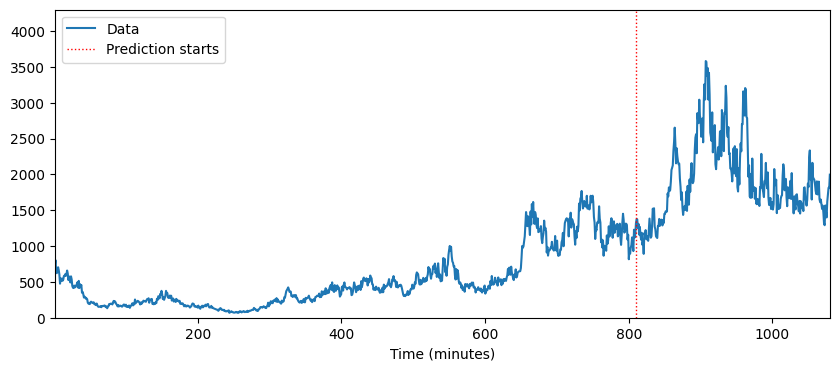

The mean of the data is 870.25.


In [2]:
# Simulate and plot a transformed process
C = np.array([1])
A = np.convolve([1, -1], [1, 0.37])
e = 0.1 * np.random.randn(N + extraN)
data = np.exp(signal.lfilter(C, A, e) + 8)
data = data[extraN:]

plt.figure(figsize=(10, 4))
plt.plot(time, data)
plt.axvline(x=time[valStart-1], color='red', linestyle=':', linewidth=1)
plt.xlabel('Time (minutes)')
plt.xlim([time[0], time[-1]])
plt.ylim([0, np.max(data)*1.2])
plt.legend(['Data', 'Prediction starts'], loc='upper left')
plt.show()

print(f'The mean of the data is {np.mean(data):.2f}.')

# Should we transform the data?

We examine all the data when making this decision. See also table 4.6.

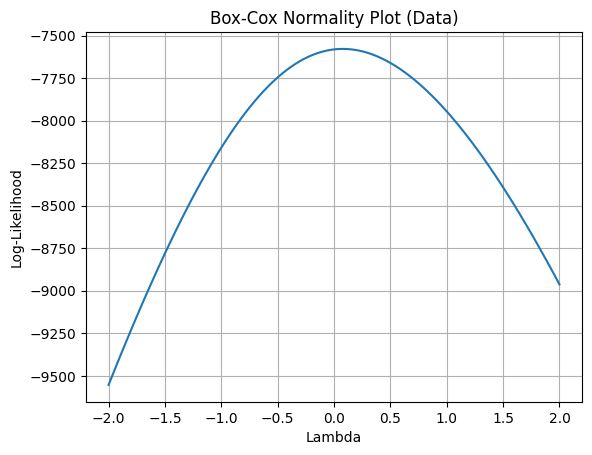

The Box-Cox curve is maximized at 0.08. This suggests that a log-transform might be helpful.


In [3]:
# Box-Cox normality plot
lambda_max, offsetValue = box_cox(data, plotIt=True, titleStr='Data', transform=False)
print(f'The Box-Cox curve is maximized at {lambda_max:.2f}. This suggests that a log-transform might be helpful.')

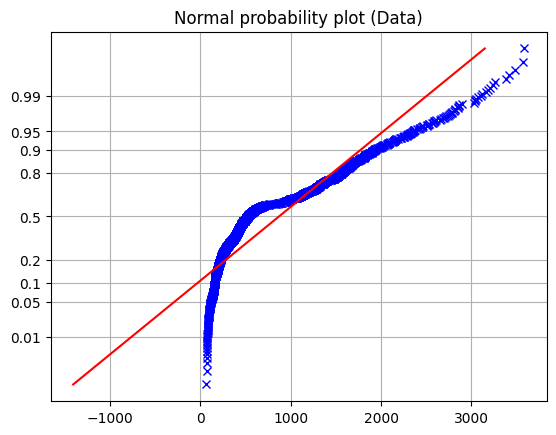

In [4]:
# Normal probability plot of original data
normplot(data, titleStr='Data')

Let's transform the data.

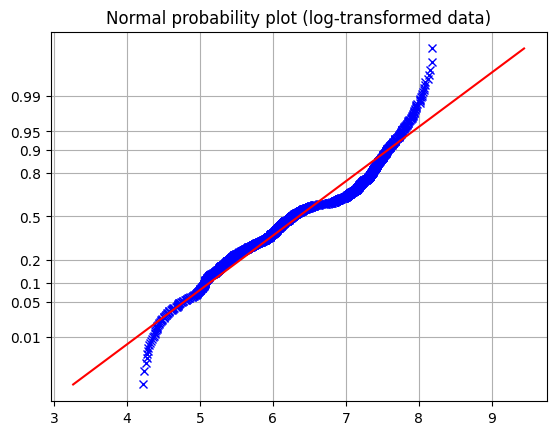

In [5]:
logData = np.log(data)

normplot(logData, titleStr='log-transformed data')

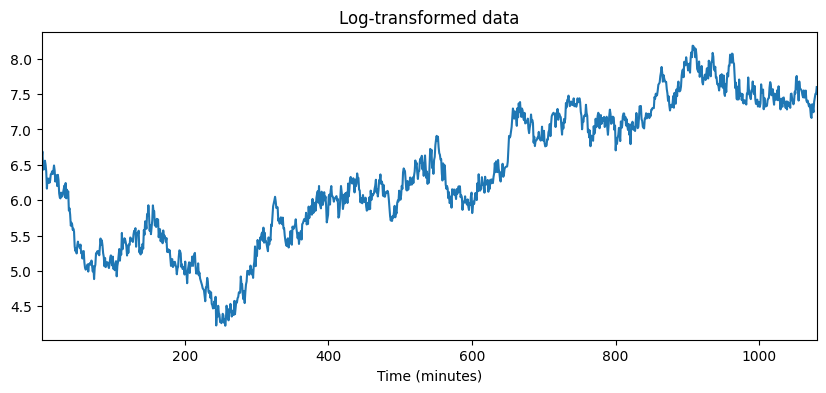

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(time, logData)
plt.title('Log-transformed data')
plt.xlabel('Time (minutes)')
plt.xlim([time[0], time[-1]])
plt.show()

Extract the modelling data and examine the ACF and PACF.

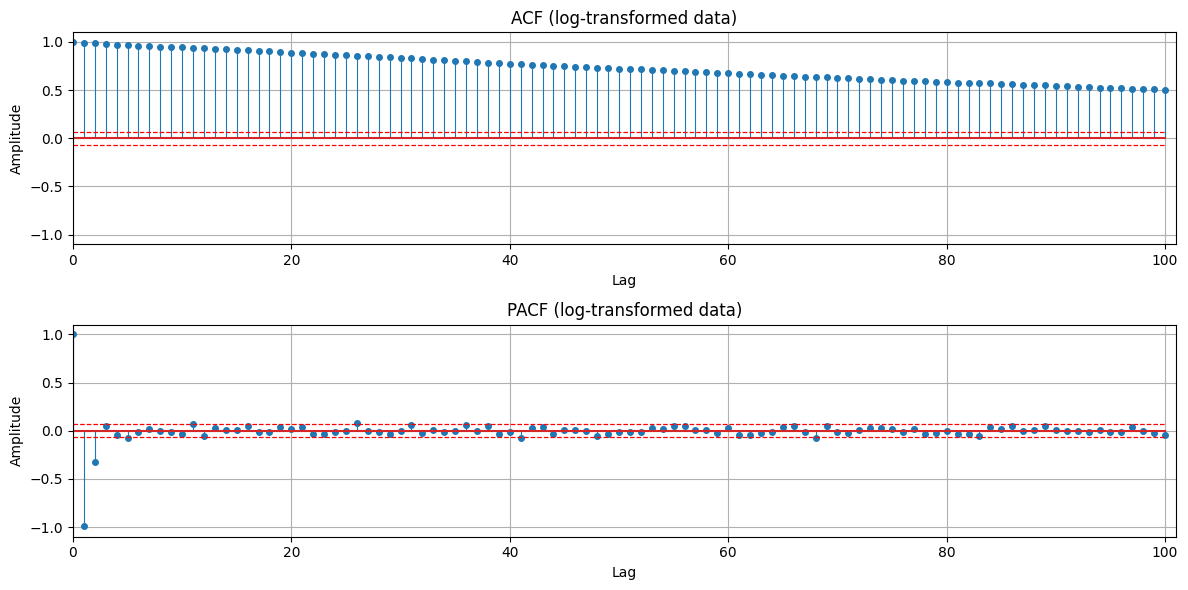

In [7]:
logModellingData = logData[:valStart]
plotACFnPACF(logModellingData, noLags, titleStr='log-transformed data')

The ACF is decaying very slowly, suggesting we need to differentiate the data.

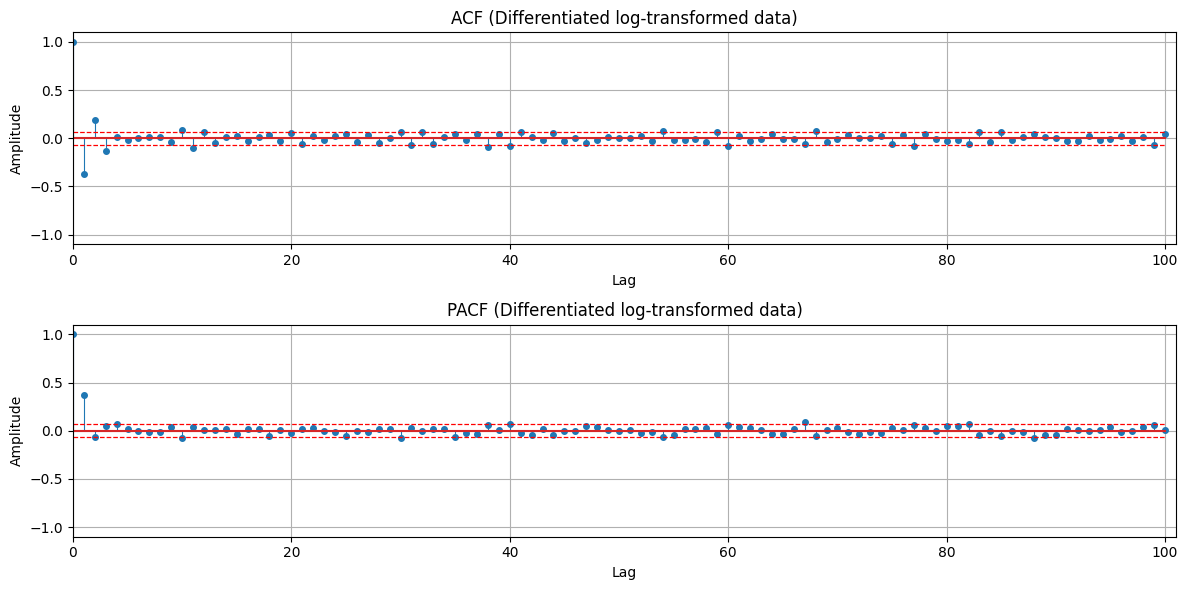

In [8]:
y = signal.lfilter([1, -1], 1, logModellingData)
y = y[1:]
plotACFnPACF(y, noLags, titleStr='Differentiated log-transformed data')

# Looks like we need an a_1 term.

Great, this gives us a white residual.

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 + 0.373(±0.031)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 7.21%
FPE : 0.011  MSE : 0.01
AIC : -1542.137   BIC : -1537.337



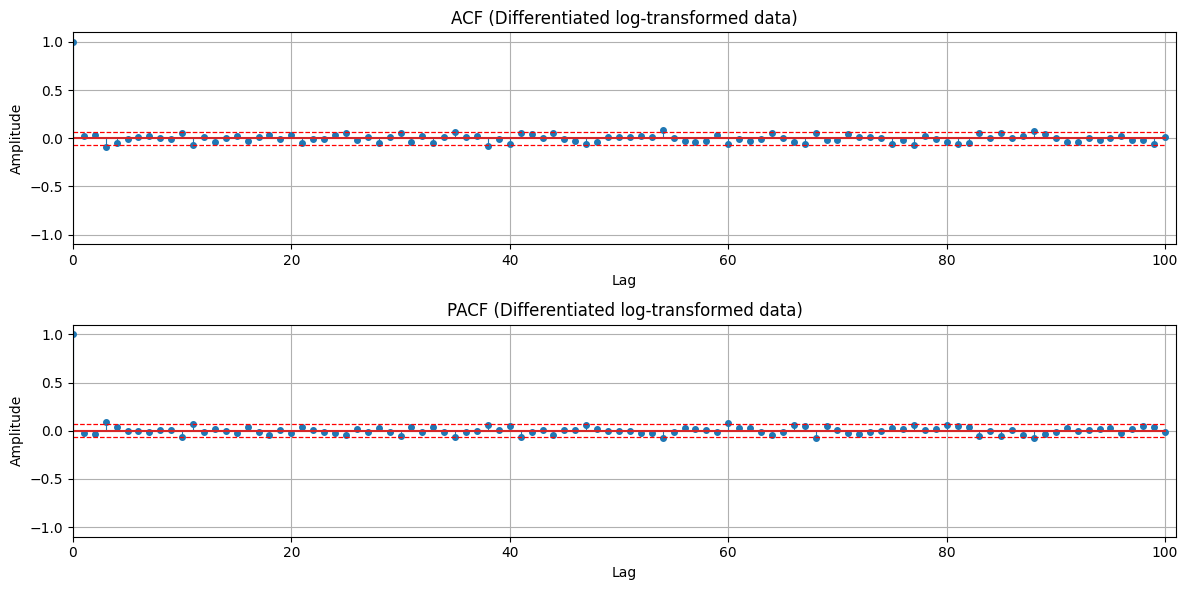

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 29.76 < 37.65)
  McLeod-Li test:        False (white if 40.87 < 37.65)
  Monti test:            True (white if 27.95 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])


In [9]:
dataModel = estimateARMA(y, np.array([1, 1]), np.array([1]), 
                         titleStr='Differentiated log-transformed data', noLags=noLags)

# Add the differentiation to the model
dataModel.A = np.convolve([1, -1], dataModel.A)

# Let's predict the signal.

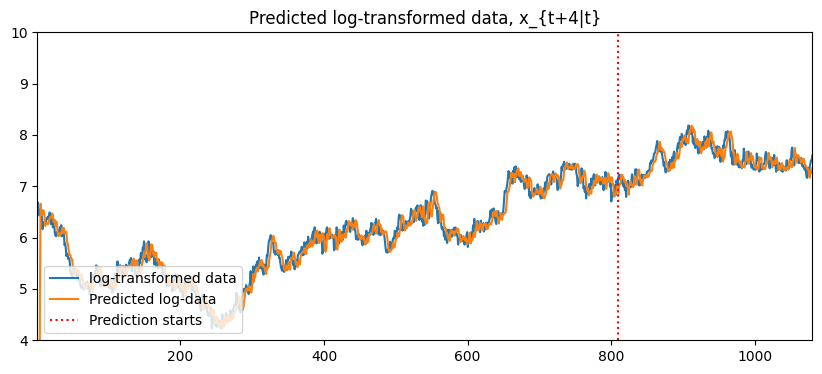

In [10]:
F, G = polydiv(dataModel.C, dataModel.A, k)
yhatk = signal.lfilter(G, dataModel.C, logData)

# This is in the wrong domain!
plt.figure(figsize=(10, 4))
plt.plot(time, logData, label='log-transformed data')
plt.plot(time, yhatk, label='Predicted log-data')
plt.axvline(x=time[valStart-1], color='red', linestyle=':', label='Prediction starts')
plt.legend(loc='lower left')
plt.title(f'Predicted log-transformed data, x_{{t+{k}|t}}')
plt.xlim([time[0], time[-1]])
plt.ylim([4, 10])
plt.show()

Let's examine the residuals.

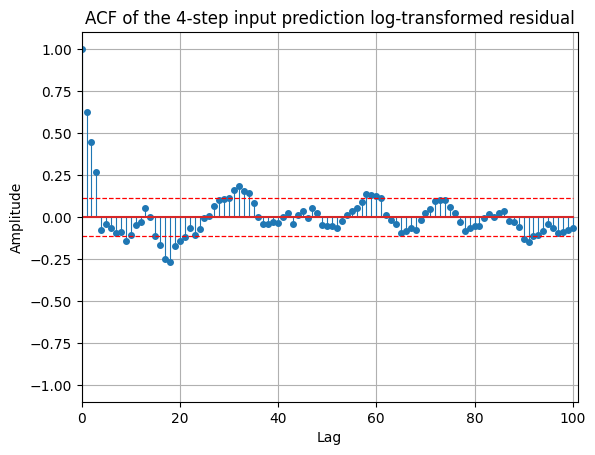

This is a 4-step prediction. Ideally, the residual should be an MA(3) process.
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 305.11 < 37.65)
  McLeod-Li test:        False (white if 74.30 < 37.65)
  Monti test:            False (white if 261.91 < 37.65)
  Sign change test:      False (white if 0.25 in [0.44,0.56])
The Jarque-Bera test indicates that the data is NOT normal distributed.


In [11]:
ehat = logData - yhatk
ehat = ehat[valStart-1:]

acfEst = acf(ehat, noLags, signLvl=0.05, plotIt=True)
plt.title(f'ACF of the {k}-step input prediction log-transformed residual')
plt.show()

print(f'This is a {k}-step prediction. Ideally, the residual should be an MA({k-1}) process.')
whiteness_test(ehat)

pacfEst = pacf(ehat, noLags, signLvl=0.05)
check_if_normal(pacfEst[k:], 'PACF (log-data)')

Plot the data in the correct domain.

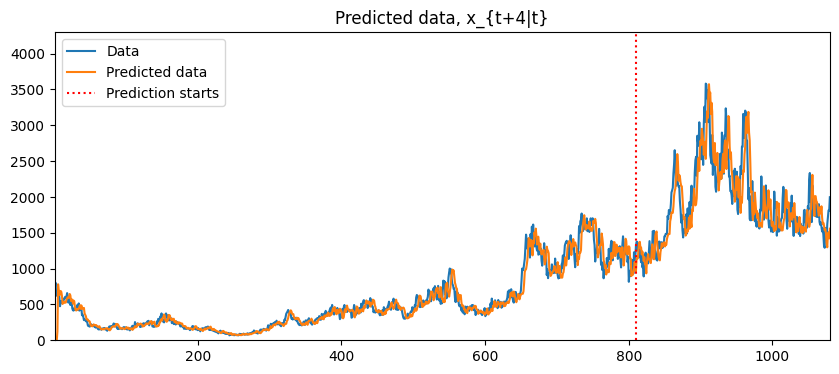

In [12]:
yhatkE = np.exp(yhatk)

plt.figure(figsize=(10, 4))
plt.plot(time, data, label='Data')
plt.plot(time, yhatkE, label='Predicted data')
plt.axvline(x=time[valStart-1], color='red', linestyle=':', label='Prediction starts')
plt.legend(loc='upper left')
plt.title(f'Predicted data, x_{{t+{k}|t}}')
plt.xlim([time[0], time[-1]])
plt.ylim([0, np.max(data)*1.2])
plt.show()

Examine the prediction residual.

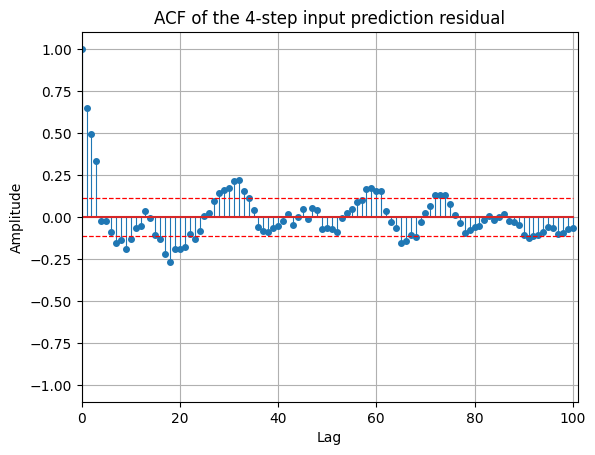

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 362.55 < 37.65)
  McLeod-Li test:        False (white if 173.84 < 37.65)
  Monti test:            False (white if 282.82 < 37.65)
  Sign change test:      False (white if 0.25 in [0.44,0.56])
The Jarque-Bera test indicates that the data is NOT normal distributed.


In [13]:
ehat = data - yhatkE
ehat = ehat[valStart-1:]

acfEst = acf(ehat, noLags, signLvl=0.05, plotIt=True)
plt.title(f'ACF of the {k}-step input prediction residual')
plt.show()

whiteness_test(ehat)

pacfEst = pacf(ehat, noLags, signLvl=0.05)
check_if_normal(pacfEst[k:], 'PACF (data)')